In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.table import Table
from sklearn.model_selection import train_test_split
import sklearn
import time
import matplotlib
import lightgbm
import catboost
import seaborn as sns

In [2]:
start = time.time()
    
#Load data:
cat = Table.read('./cosmos2020cat/galaxies_flag.fits', format='fits', hdu=1)
data = cat.to_pandas()
data = data.dropna()

total_time = (time.time() - start)
print(f'Total needed time for loading data: {total_time/60} minutes')

Total needed time for loading data: 0.05421883265177409 minutes


In [3]:
data

,HSC_g_FLUX_APER3,HSC_g_FLUXERR_APER3,HSC_r_FLUX_APER3,HSC_r_FLUXERR_APER3,HSC_i_FLUX_APER3,HSC_i_FLUXERR_APER3,HSC_z_FLUX_APER3,HSC_z_FLUXERR_APER3,HSC_y_FLUX_APER3,HSC_y_FLUXERR_APER3,...,SC_zp_FLUX_APER3,SC_zp_FLUXERR_APER3,SC_zpp_FLUX_APER3,SC_zpp_FLUXERR_APER3,lp_zBEST,lp_chi2_best,lp_age,lp_dust,lp_mass_best,lp_SFR_best
74881,0.059588,0.009353,0.102227,0.011827,0.103191,0.013726,0.072449,0.021317,0.094179,0.042004,...,-0.054365,0.106193,0.062646,0.066935,0.2204,0.274431,1.278000e+09,0.0,6.26138,-2.4310
74898,0.034955,0.009369,0.042094,0.011633,0.054346,0.013762,0.094934,0.022022,0.067392,0.043432,...,0.108576,0.097631,0.110174,0.061370,1.5378,0.243877,5.000000e+07,0.3,8.04912,0.4298
74909,0.035636,0.009112,0.050710,0.011390,0.067311,0.013618,0.060902,0.022174,0.057592,0.042177,...,-0.066770,0.105607,-0.007303,0.069209,2.0924,0.168860,1.278000e+08,0.2,8.27846,0.2578
74915,0.295763,0.011651,0.421066,0.013991,0.769023,0.017079,1.011719,0.024828,1.223038,0.043347,...,1.139818,0.089320,1.050521,0.055803,0.9529,0.544113,8.064000e+08,0.2,9.18463,0.2710
74931,0.368599,0.012837,0.395942,0.014677,0.401682,0.015777,0.557208,0.024713,0.662832,0.043869,...,0.595227,0.104156,0.521348,0.067087,1.1493,0.800057,1.805000e+08,0.1,8.43146,0.2910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710713,-0.036355,0.012855,0.026024,0.018093,0.074752,0.023470,0.053254,0.036301,-0.039609,0.075763,...,0.073403,0.118105,0.080103,0.078485,4.3340,0.121252,5.000000e+07,0.3,8.91999,1.5790
710714,0.664295,0.017590,0.897905,0.023672,1.354753,0.029294,2.278479,0.045063,2.476339,0.083915,...,2.310444,0.114276,2.196419,0.089520,1.0989,0.697465,1.139000e+09,0.2,9.81574,0.8984
710715,0.049303,0.013577,0.137606,0.019217,0.185789,0.024987,0.245228,0.037620,0.320116,0.079436,...,0.108938,0.119425,0.280250,0.090902,0.3696,0.211670,1.278000e+09,0.0,7.60325,-2.5050
710716,5.917768,0.040330,12.748120,0.058757,16.185408,0.061223,18.327394,0.078146,22.885693,0.117169,...,19.684599,0.112916,19.940647,0.084672,0.4340,1.320150,1.800000e+09,0.2,9.86645,0.8036


# Redshift

In [4]:
#Group columns into features (x) and labels (y), with their errors:
y = data[['lp_zBEST', 'lp_age', 'lp_dust', 'lp_mass_best', 'lp_SFR_best']].copy()
x = data[['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()
x_err = data[['HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()

#Train validation test split:
x_train, x_testval, y_train, y_testval, x_err_train, x_err_testval = train_test_split(x, y, x_err, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val , x_err_test, x_err_val = train_test_split(x_testval, y_testval, x_err_testval, test_size=0.5, shuffle = True)

In [5]:
y_train = y_train['lp_zBEST'] + 1 # Only redshifts for now, but 1+z.
y_val = y_val['lp_zBEST'] + 1
y_test = y_test['lp_zBEST'] + 1

In [6]:
start = time.time()
def metric_scores_rgr(x,y):
    """Computes the NMAD, bias, outlier fraction for the regression tasks
    x: ground-truth data
    y: predicted data
    """
    met = np.abs(pd.Series(y-x))
    f_out = met/(1+x.astype(np.float32))
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.15, 'outlier', 'not outlier'))
    r2 = sklearn.metrics.r2_score(x, y)
    #print("Outliers: \n", y_outlier.value_counts())
    outlier_fraction = y_outlier.value_counts()['outlier'] / len(y_outlier)
    #print("Outlier fraction: \n", outlier_fraction)
    #print("\n Bias: \n", bias)
    #print("\n NMAD score: \n", nmad)
    #print('\n R2 Test: \n', r2)
    return outlier_fraction, nmad, bias, r2

metrics = {'n_estimators': [], 'max_depth': [], 'outlier_fraction': [], 'NMAD': [], 'bias': [], 'r2': []}
metrics = pd.DataFrame(data=metrics)
for i in [50, 100, 150]:
    for j in [0, 4, 7, 9]:
        metrics['n_estimators']
        model = catboost.CatBoostRegressor(n_estimators = i, max_depth = j, verbose = 0)
        model.fit(x_train, y_train) # sample_weight = x_err_train
        pred_z = model.predict(x_val)
        # Tests for metric tuning:
        outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_val, pred_z)
        new_row = pd.DataFrame([[i, j, outlier_fraction, nmad, bias, r2]], columns=['n_estimators', 'max_depth', 'outlier_fraction', 'NMAD', 'bias', 'r2'])
        metrics = pd.concat([metrics, new_row], axis = 0)
        
print(metrics)

total_time = (time.time() - start)
print(f'Total needed time for catboost: {total_time/60} minutes')

   n_estimators  max_depth  outlier_fraction      NMAD      bias        r2
0          50.0        0.0          0.693138  0.365487  0.246951 -0.000013
0          50.0        4.0          0.420958  0.176156  0.119025  0.435309
0          50.0        7.0          0.379420  0.153170  0.103493  0.471331
0          50.0        9.0          0.363111  0.144367  0.097545  0.478964
0         100.0        0.0          0.693138  0.365487  0.246951 -0.000013
0         100.0        4.0          0.395003  0.162114  0.109536  0.458089
0         100.0        7.0          0.358708  0.140731  0.095088  0.484075
0         100.0        9.0          0.349916  0.135566  0.091599  0.484166
0         150.0        0.0          0.693138  0.365487  0.246951 -0.000013
0         150.0        4.0          0.377452  0.151403  0.102299  0.475152
0         150.0        7.0          0.351094  0.136125  0.091976  0.489543
0         150.0        9.0          0.340996  0.131070  0.088561  0.489498
Total needed time for cat

Outlier fraction: 
 0.34414117950703316

 Bias: 
 0.08921893464526323

 NMAD score: 
 0.13204402327498957

 R2 Test: 
 0.47734205518789563


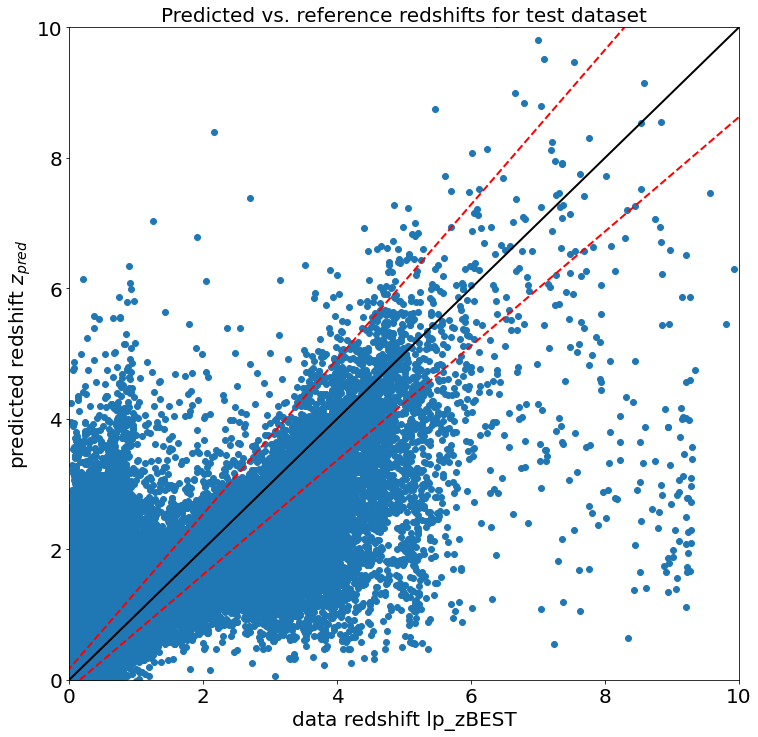

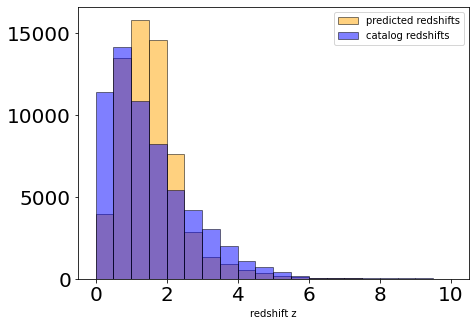

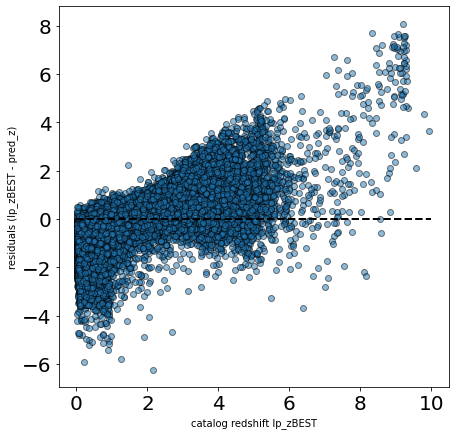

In [7]:
#Test:

model = catboost.CatBoostRegressor(n_estimators = 150, max_depth = 9, verbose = 0)
model.fit(x_train, y_train) # sample_weight = x_err_train
pred_z = model.predict(x_test)
#Metrics:
outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_test, pred_z)
print("Outlier fraction: \n", outlier_fraction)
print("\n Bias: \n", bias)
print("\n NMAD score: \n", nmad)
print('\n R2 Test: \n', r2)

plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.scatter(y_test-1, pred_z-1)
plt.title('Predicted vs. reference redshifts for test dataset', fontsize = 20)
plt.xlabel('data redshift lp_zBEST', fontsize = 20)
plt.ylabel('predicted redshift $z_{pred}$', fontsize = 20)
plt.xlim(0,10)
plt.ylim(0,10)
x0, x1 = 0, 10
y0, y1 = 0, 10
plt.plot([np.min(y_test-1)-0.15*(1+np.min(y_test-1)), np.max(y_test-1)-0.150*(np.max(y_test-1)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([np.min(y_test-1)+0.15*(1+np.min(y_test-1)), np.max(y_test-1)+0.150*(np.max(y_test-1)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2)


# Histogram:
fig_hist = plt.figure(figsize=(7,5))
plt.hist(pred_z-1, 20, range = (0,10),facecolor='orange', edgecolor = 'black', alpha=0.5, label = 'predicted redshifts')
plt.hist(y_test-1, 20, range = (0,10), facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'catalog redshifts')
plt.xlabel('redshift z')
plt.legend()
# Residuals:
residuals = y_test - pred_z
fig_res = plt.figure(figsize=(7,7))
plt.scatter(y_test-1, residuals, alpha = 0.5, edgecolor = 'black')
plt.xlabel('catalog redshift lp_zBEST')
plt.ylabel('residuals (lp_zBEST - pred_z)')
x0, x1 = 0, 10
y0, y1 = 0, 0
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2, linestyle = 'dashed')

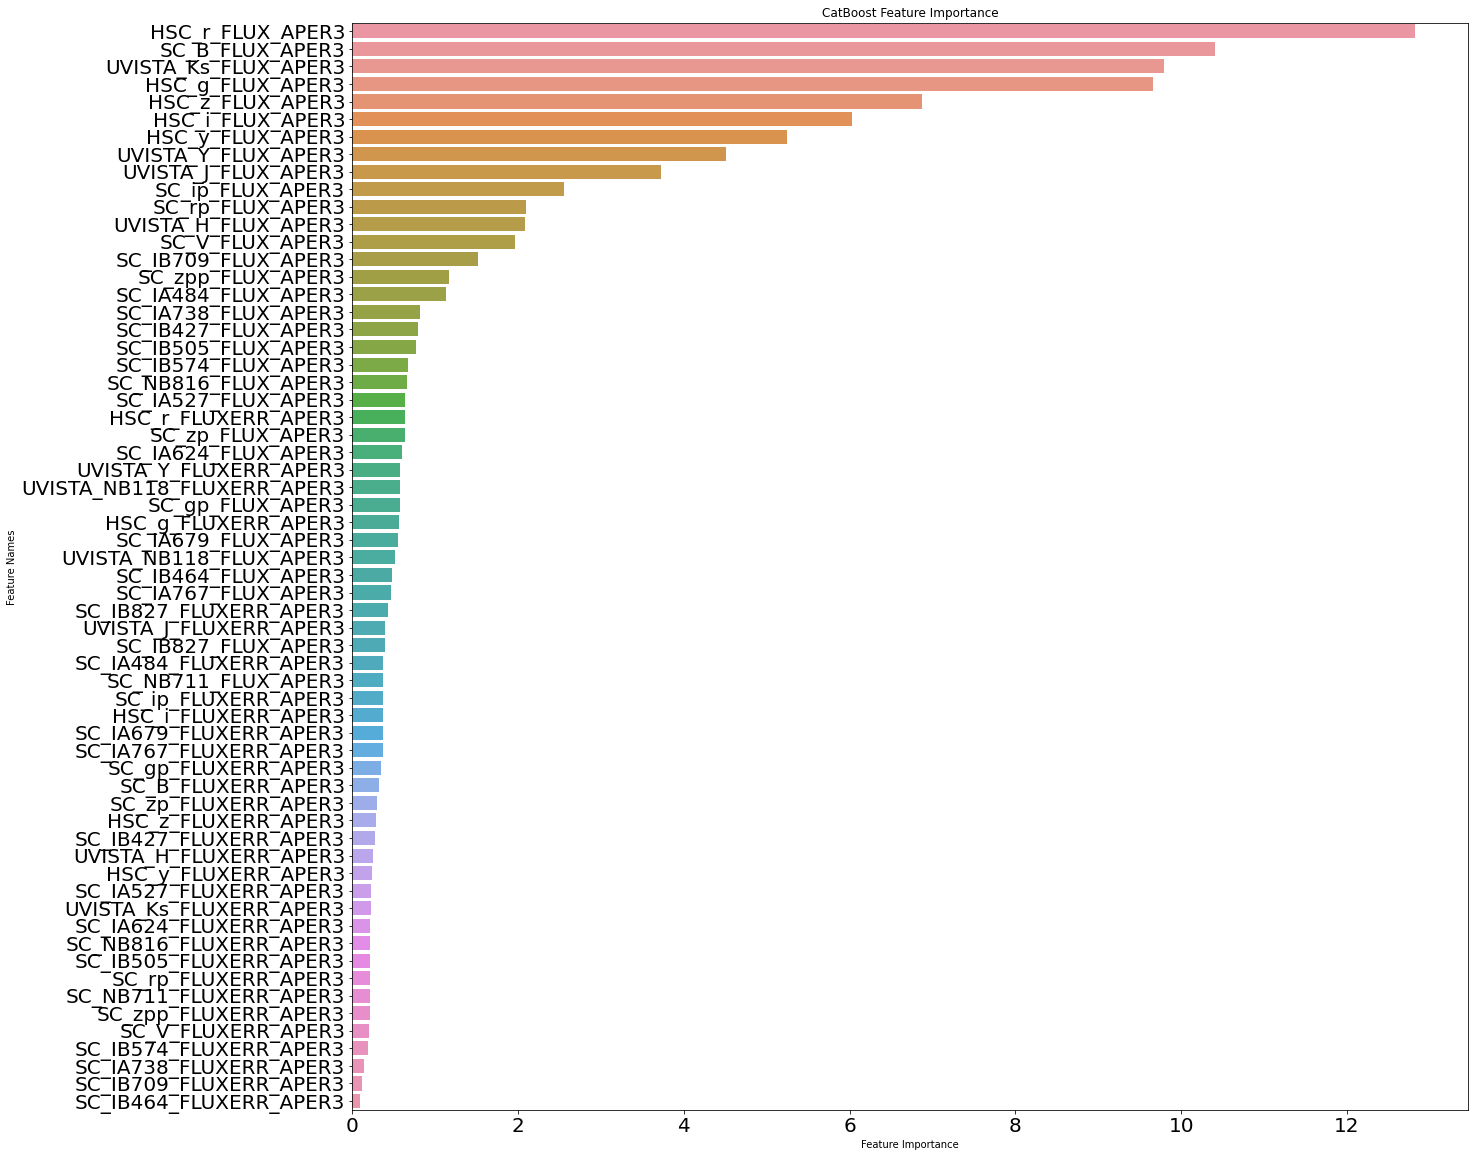

In [8]:
# Feature importance:
def plot_feature_importance(importance,names,model_type):
    """Plots feature importance
    importance: features importance output from model
    names: features names
    model_type: name of the model used to compute features importance
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

features_importances = model.feature_importances_ #replace model by your model
names = np.array(['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3'])#list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.

plot_feature_importance(features_importances,names,model_type)

# Age:

In [9]:
#Group columns into features (x) and labels (y), with their errors:
y = data[['lp_zBEST', 'lp_age', 'lp_dust', 'lp_mass_best', 'lp_SFR_best']].copy()
x = data[['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()
y_z_err = data[['lp_chi2_best']].copy()
x_err = data[['HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()

#Train validation test split:
x_train, x_testval, y_train, y_testval, x_err_train, x_err_testval = train_test_split(x, y, x_err, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val , x_err_test, x_err_val = train_test_split(x_testval, y_testval, x_err_testval, test_size=0.5, shuffle = True)

In [10]:
y_train = y_train['lp_age'] #Ages
y_val = y_val['lp_age']
y_test = y_test['lp_age']

In [11]:
start = time.time()

def metric_scores_rgr(x,y):
    """Computes the NMAD, bias, outlier fraction for the regression tasks
    x: ground-truth data
    y: predicted data
    """
    met = np.abs(pd.Series(y-x))
    f_out = met
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.30, 'outlier', 'not outlier'))
    r2 = sklearn.metrics.r2_score(x, y)
    #print("Outliers: \n", y_outlier.value_counts())
    outlier_fraction = y_outlier.value_counts()['outlier'] / len(y_outlier)
    #print("Outlier fraction: \n", outlier_fraction)
    #print("\n Bias: \n", bias)
    #print("\n NMAD score: \n", nmad)
    #print('\n R2 Test: \n', r2)
    return outlier_fraction, nmad, bias, r2

metrics = {'n_estimators': [], 'max_depth': [], 'outlier_fraction': [], 'NMAD': [], 'bias': [], 'r2': []}
metrics = pd.DataFrame(data=metrics)
for i in [50, 100, 150]:
    for j in [0, 4, 7, 9]:
        metrics['n_estimators']
        model = catboost.CatBoostRegressor(n_estimators = i, max_depth = j, verbose = 0)
        model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
        pred_z = model.predict(x_val)
        # Tests for metric tuning:
        outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_val, pred_z)
        new_row = pd.DataFrame([[i, j, outlier_fraction, nmad, bias, r2]], columns=['n_estimators', 'max_depth', 'outlier_fraction', 'NMAD', 'bias', 'r2'])
        metrics = pd.concat([metrics, new_row], axis = 0)
        
print(metrics)

total_time = (time.time() - start)
print(f'Total needed time for catboost: {total_time/60} minutes')

   n_estimators  max_depth  outlier_fraction          NMAD          bias  \
0          50.0        0.0               1.0  1.452671e+09  9.815347e+08   
0          50.0        4.0               1.0  9.571642e+08  6.467325e+08   
0          50.0        7.0               1.0  9.217053e+08  6.227739e+08   
0          50.0        9.0               1.0  9.079065e+08  6.134504e+08   
0         100.0        0.0               1.0  1.452671e+09  9.815347e+08   
0         100.0        4.0               1.0  9.436215e+08  6.375821e+08   
0         100.0        7.0               1.0  9.031724e+08  6.102516e+08   
0         100.0        9.0               1.0  8.977893e+08  6.066144e+08   
0         150.0        0.0               1.0  1.452671e+09  9.815347e+08   
0         150.0        4.0               1.0  9.284548e+08  6.273344e+08   
0         150.0        7.0               1.0  8.938824e+08  6.039746e+08   
0         150.0        9.0               1.0  8.909588e+08  6.019992e+08   

         r2

Outlier fraction: 
 1.0

 Bias: 
 599436140.3616124

 NMAD score: 
 887165487.7351865

 R2 Test: 
 0.2804091539289806


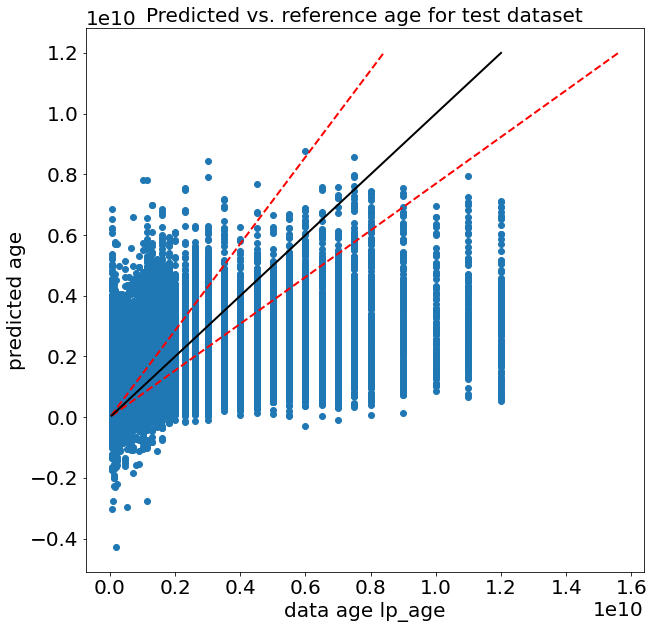

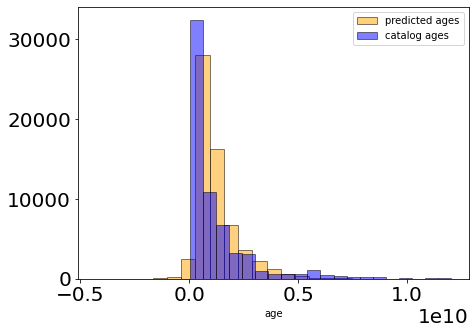

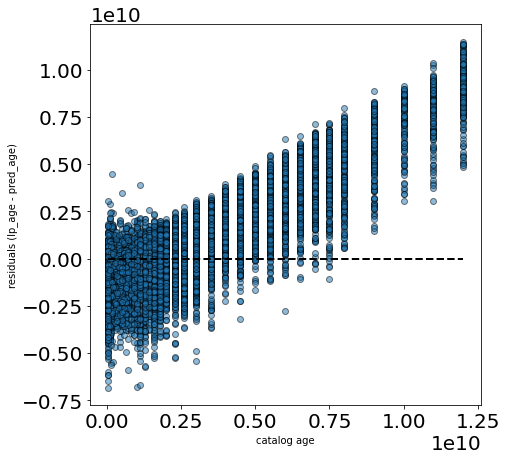

In [12]:
#Test:

model = catboost.CatBoostRegressor(n_estimators = 150, max_depth = 9, verbose = 0)
model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
pred_z = model.predict(x_test)
#Metrics:
outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_test, pred_z)
print("Outlier fraction: \n", outlier_fraction)
print("\n Bias: \n", bias)
print("\n NMAD score: \n", nmad)
print('\n R2 Test: \n', r2)

plt.figure(figsize=(10,10))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.scatter(y_test, pred_z)
plt.title('Predicted vs. reference age for test dataset', fontsize = 20)
plt.xlabel('data age lp_age', fontsize = 20)
plt.ylabel('predicted age', fontsize = 20)
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = np.min(y_test), np.max(y_test)
plt.plot([np.min(y_test)-0.3*(1+np.min(y_test)), np.max(y_test)-0.30*(np.max(y_test)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([np.min(y_test)+0.3*(1+np.min(y_test)), np.max(y_test)+0.30*(np.max(y_test)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2)


# Histogram:
fig_hist = plt.figure(figsize=(7,5))
plt.hist(pred_z, 20,facecolor='orange', edgecolor = 'black', alpha=0.5, label = 'predicted ages')
plt.hist(y_test, 20, facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'catalog ages')
plt.xlabel('age')
plt.legend()
# Residuals:
residuals = y_test - pred_z
fig_res = plt.figure(figsize=(7,7))
plt.scatter(y_test, residuals, alpha = 0.5, edgecolor = 'black')
plt.xlabel('catalog age')
plt.ylabel('residuals (lp_age - pred_age)')
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = 0, 0
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2, linestyle = 'dashed')

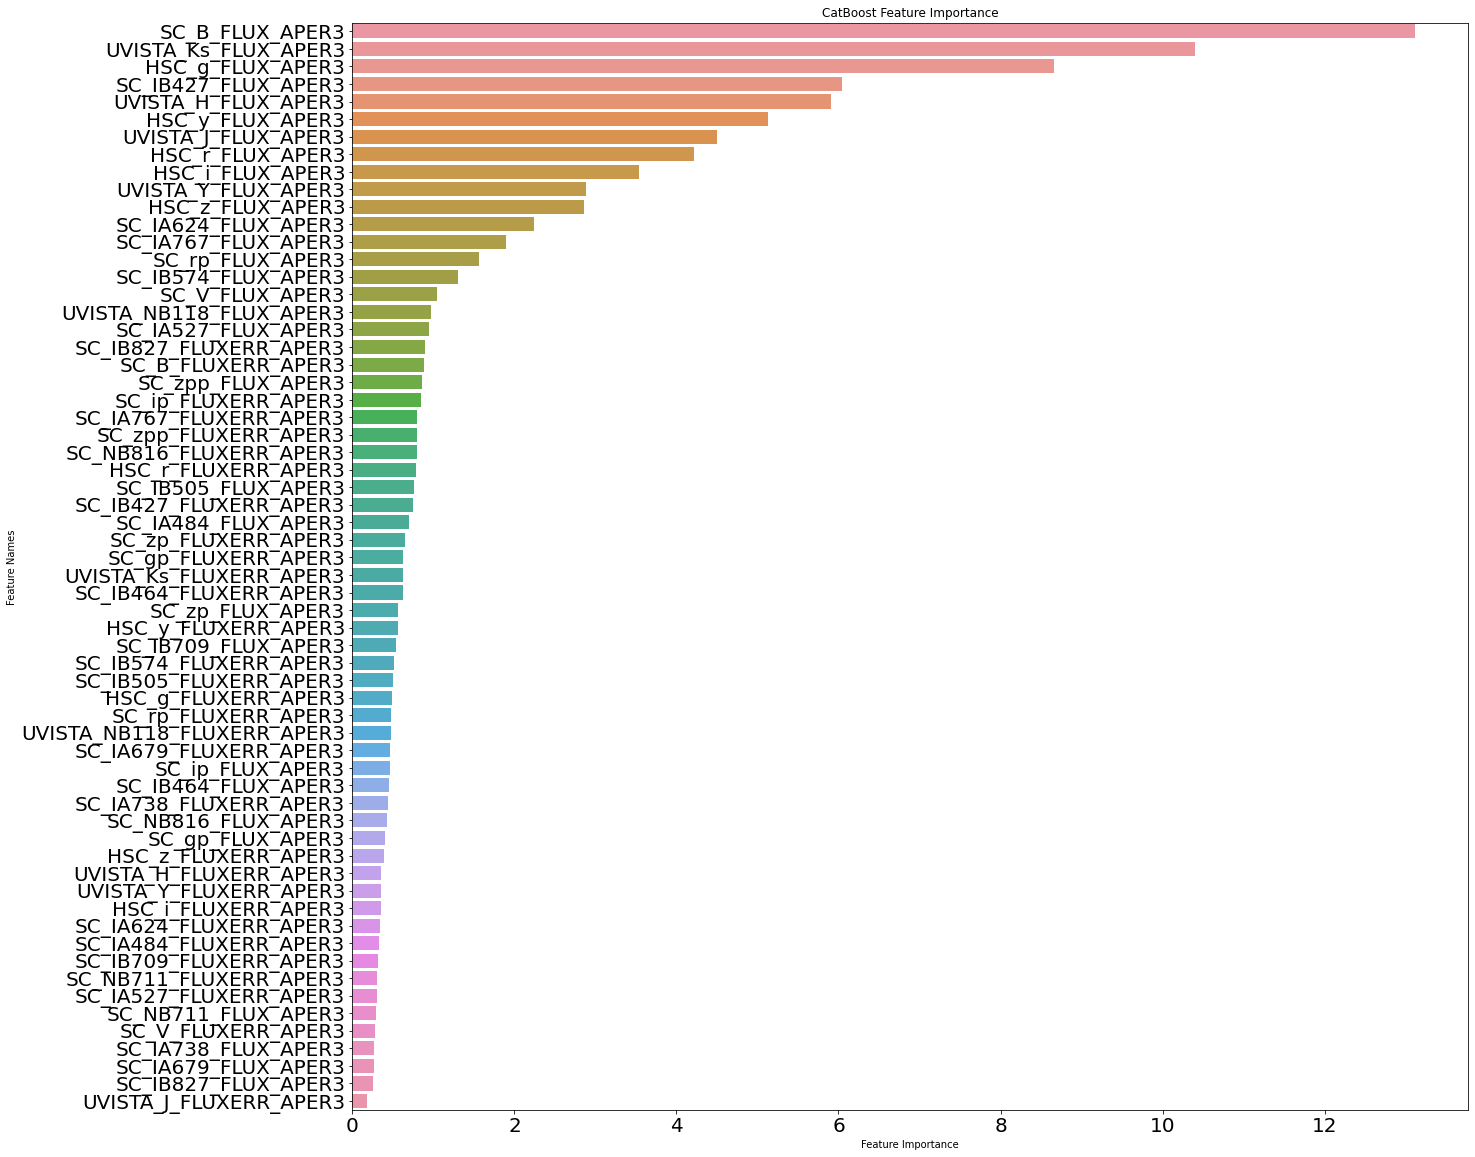

In [13]:
# Feature importance:
def plot_feature_importance(importance,names,model_type):
    """Plots feature importance
    importance: features importance output from model
    names: features names
    model_type: name of the model used to compute features importance
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

features_importances = model.feature_importances_ #replace model by your model
names = np.array(['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3'])#list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.

plot_feature_importance(features_importances,names,model_type)

# Dust

In [14]:
#Group columns into features (x) and labels (y), with their errors:
y = data[['lp_zBEST', 'lp_age', 'lp_dust', 'lp_mass_best', 'lp_SFR_best']].copy()
x = data[['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()
y_z_err = data[['lp_chi2_best']].copy()
x_err = data[['HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()

#Train validation test split:
x_train, x_testval, y_train, y_testval, x_err_train, x_err_testval = train_test_split(x, y, x_err, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val , x_err_test, x_err_val = train_test_split(x_testval, y_testval, x_err_testval, test_size=0.5, shuffle = True)

In [15]:
y_train = y_train['lp_dust'] #Dust
y_val = y_val['lp_dust']
y_test = y_test['lp_dust']

In [16]:
start = time.time()

def metric_scores_rgr(x,y):
    """Computes the NMAD, bias, outlier fraction for the regression tasks
    x: ground-truth data
    y: predicted data
    """
    met = np.abs(pd.Series(y-x))
    f_out = met
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.30, 'outlier', 'not outlier'))
    r2 = sklearn.metrics.r2_score(x, y)
    #print("Outliers: \n", y_outlier.value_counts())
    outlier_fraction = y_outlier.value_counts()['outlier'] / len(y_outlier)
    #print("Outlier fraction: \n", outlier_fraction)
    #print("\n Bias: \n", bias)
    #print("\n NMAD score: \n", nmad)
    #print('\n R2 Test: \n', r2)
    return outlier_fraction, nmad, bias, r2


metrics = {'n_estimators': [], 'max_depth': [], 'outlier_fraction': [], 'NMAD': [], 'bias': [], 'r2': []}
metrics = pd.DataFrame(data=metrics)
for i in [50, 100, 150]:
    for j in [0, 4, 7, 9]:
        metrics['n_estimators']
        model = catboost.CatBoostRegressor(n_estimators = i, max_depth = j, verbose = 0)
        model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
        pred_z = model.predict(x_val)
        # Tests for metric tuning:
        outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_val, pred_z)
        new_row = pd.DataFrame([[i, j, outlier_fraction, nmad, bias, r2]], columns=['n_estimators', 'max_depth', 'outlier_fraction', 'NMAD', 'bias', 'r2'])
        metrics = pd.concat([metrics, new_row], axis = 0)
        
print(metrics)

total_time = (time.time() - start)
print(f'Total needed time for catboost: {total_time/60} minutes')

   n_estimators  max_depth  outlier_fraction      NMAD      bias        r2
0          50.0        0.0          0.045232  0.079590  0.053777 -0.000909
0          50.0        4.0          0.032133  0.110991  0.074994  0.265226
0          50.0        7.0          0.029423  0.105458  0.071256  0.297349
0          50.0        9.0          0.028907  0.103738  0.070093  0.309872
0         100.0        0.0          0.045232  0.079590  0.053777 -0.000909
0         100.0        4.0          0.030004  0.107814  0.072847  0.286612
0         100.0        7.0          0.028358  0.102849  0.069493  0.316370
0         100.0        9.0          0.028278  0.100413  0.067847  0.323261
0         150.0        0.0          0.045232  0.079590  0.053777 -0.000909
0         150.0        4.0          0.029052  0.105068  0.070992  0.300859
0         150.0        7.0          0.027858  0.100254  0.067739  0.328122
0         150.0        9.0          0.027729  0.098834  0.066780  0.324354
Total needed time for cat

Outlier fraction: 
 0.027455155503935992

 Bias: 
 0.06711236729891873

 NMAD score: 
 0.09932630360239972

 R2 Test: 
 0.3319232308436585


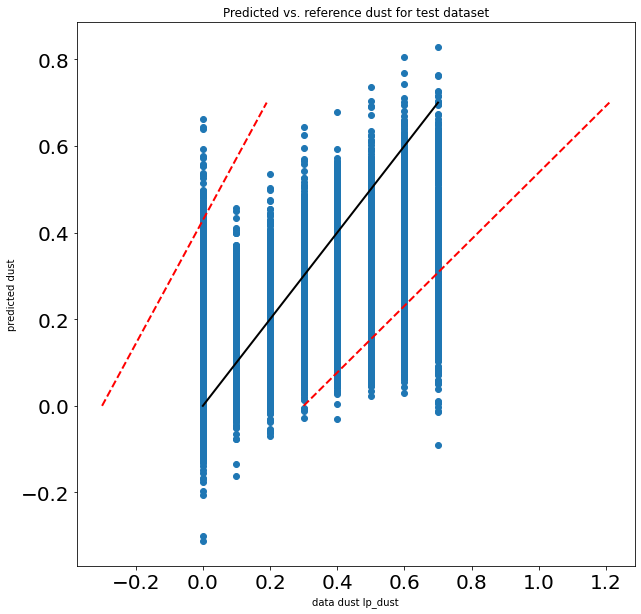

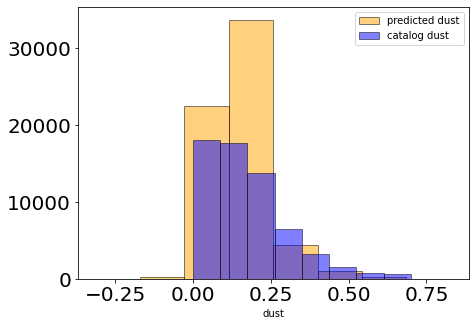

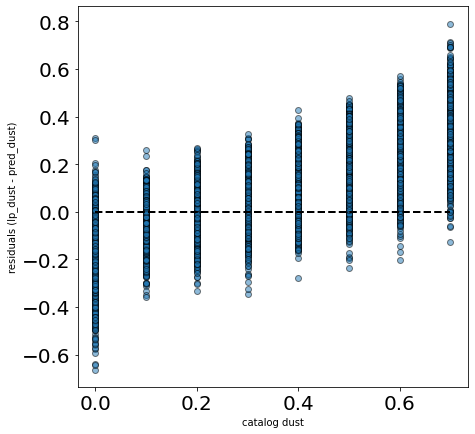

In [17]:
#Test:

model = catboost.CatBoostRegressor(n_estimators = 150, max_depth = 9, verbose = 0)
model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
pred_z = model.predict(x_test)
#Metrics:
outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_test, pred_z)
print("Outlier fraction: \n", outlier_fraction)
print("\n Bias: \n", bias)
print("\n NMAD score: \n", nmad)
print('\n R2 Test: \n', r2)

plt.figure(figsize=(10,10))
plt.scatter(y_test, pred_z)
plt.title('Predicted vs. reference dust for test dataset')
plt.xlabel('data dust lp_dust')
plt.ylabel('predicted dust')
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = np.min(y_test), np.max(y_test)
plt.plot([np.min(y_test)-0.3*(1+np.min(y_test)), np.max(y_test)-0.30*(np.max(y_test)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([np.min(y_test)+0.3*(1+np.min(y_test)), np.max(y_test)+0.30*(np.max(y_test)+1)], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2)


# Histogram:
fig_hist = plt.figure(figsize=(7,5))
plt.hist(pred_z, 8,facecolor='orange', edgecolor = 'black', alpha=0.5, label = 'predicted dust')
plt.hist(y_test, 8, facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'catalog dust')
plt.xlabel('dust')
plt.legend()
# Residuals:
residuals = y_test - pred_z
fig_res = plt.figure(figsize=(7,7))
plt.scatter(y_test, residuals, alpha = 0.5, edgecolor = 'black')
plt.xlabel('catalog dust')
plt.ylabel('residuals (lp_dust - pred_dust)')
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = 0, 0
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2, linestyle = 'dashed')

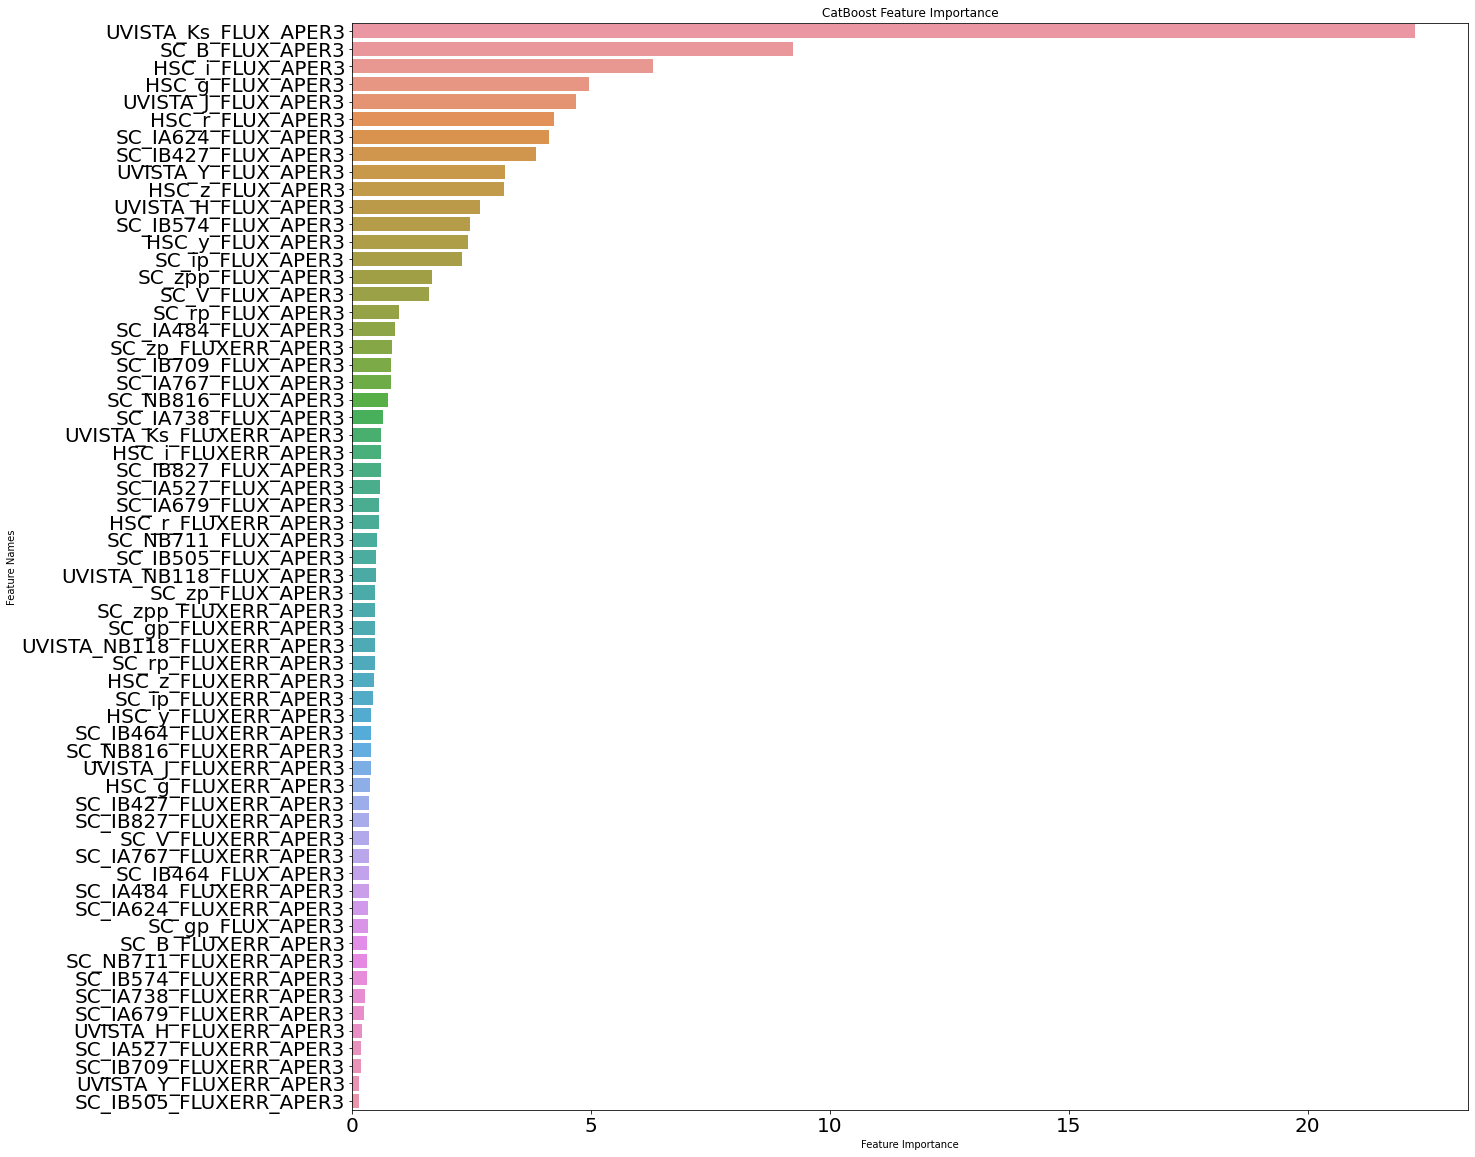

In [18]:
# Feature importance:
def plot_feature_importance(importance,names,model_type):
    """Plots feature importance
    importance: features importance output from model
    names: features names
    model_type: name of the model used to compute features importance
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

features_importances = model.feature_importances_ #replace model by your model
names = np.array(['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3'])#list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.

plot_feature_importance(features_importances,names,model_type)

# Mass

In [19]:
#Group columns into features (x) and labels (y), with their errors:
y = data[['lp_zBEST', 'lp_age', 'lp_dust', 'lp_mass_best', 'lp_SFR_best']].copy()
x = data[['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()
y_z_err = data[['lp_chi2_best']].copy()
x_err = data[['HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()

#Train validation test split:
x_train, x_testval, y_train, y_testval, x_err_train, x_err_testval = train_test_split(x, y, x_err, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val , x_err_test, x_err_val = train_test_split(x_testval, y_testval, x_err_testval, test_size=0.5, shuffle = True)

In [20]:
y_train = y_train['lp_mass_best'] #Masses
y_val = y_val['lp_mass_best']
y_test = y_test['lp_mass_best']

In [21]:
start = time.time()

def metric_scores_rgr(x,y):
    """Computes the NMAD, bias, outlier fraction for the regression tasks
    x: ground-truth data
    y: predicted data
    """
    met = np.abs(pd.Series(y-x))
    f_out = met
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.30, 'outlier', 'not outlier'))
    r2 = sklearn.metrics.r2_score(x, y)
    #print("Outliers: \n", y_outlier.value_counts())
    outlier_fraction = y_outlier.value_counts()['outlier'] / len(y_outlier)
    #print("Outlier fraction: \n", outlier_fraction)
    #print("\n Bias: \n", bias)
    #print("\n NMAD score: \n", nmad)
    #print('\n R2 Test: \n', r2)
    return outlier_fraction, nmad, bias, r2

metrics = {'n_estimators': [], 'max_depth': [], 'outlier_fraction': [], 'NMAD': [], 'bias': [], 'r2': []}
metrics = pd.DataFrame(data=metrics)
for i in [50, 100, 150]:
    for j in [0, 4, 7, 9]:
        metrics['n_estimators']
        model = catboost.CatBoostRegressor(n_estimators = i, max_depth = j, verbose = 0)
        model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
        pred_z = model.predict(x_val)
        # Tests for metric tuning:
        outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_val, pred_z)
        new_row = pd.DataFrame([[i, j, outlier_fraction, nmad, bias, r2]], columns=['n_estimators', 'max_depth', 'outlier_fraction', 'NMAD', 'bias', 'r2'])
        metrics = pd.concat([metrics, new_row], axis = 0)
        
print(metrics)

total_time = (time.time() - start)
print(f'Total needed time for catboost: {total_time/60} minutes')

   n_estimators  max_depth  outlier_fraction      NMAD      bias        r2
0          50.0        0.0          0.754081  0.972450  0.657060 -0.012654
0          50.0        4.0          0.568299  0.541345  0.365774  0.518417
0          50.0        7.0          0.551813  0.516792  0.349184  0.532441
0          50.0        9.0          0.539618  0.499281  0.337352  0.538397
0         100.0        0.0          0.754081  0.972450  0.657060 -0.012654
0         100.0        4.0          0.556152  0.523303  0.353583  0.529170
0         100.0        7.0          0.534730  0.491592  0.332156  0.543047
0         100.0        9.0          0.532375  0.488269  0.329911  0.540612
0         150.0        0.0          0.754081  0.972450  0.657060 -0.012654
0         150.0        4.0          0.546329  0.509147  0.344018  0.535979
0         150.0        7.0          0.529359  0.484857  0.327606  0.546222
0         150.0        9.0          0.527697  0.482447  0.325978  0.540693
Total needed time for cat

Outlier fraction: 
 0.5295522002839076

 Bias: 
 0.32801674259536107

 NMAD score: 
 0.4854647790411344

 R2 Test: 
 0.5373896172767267


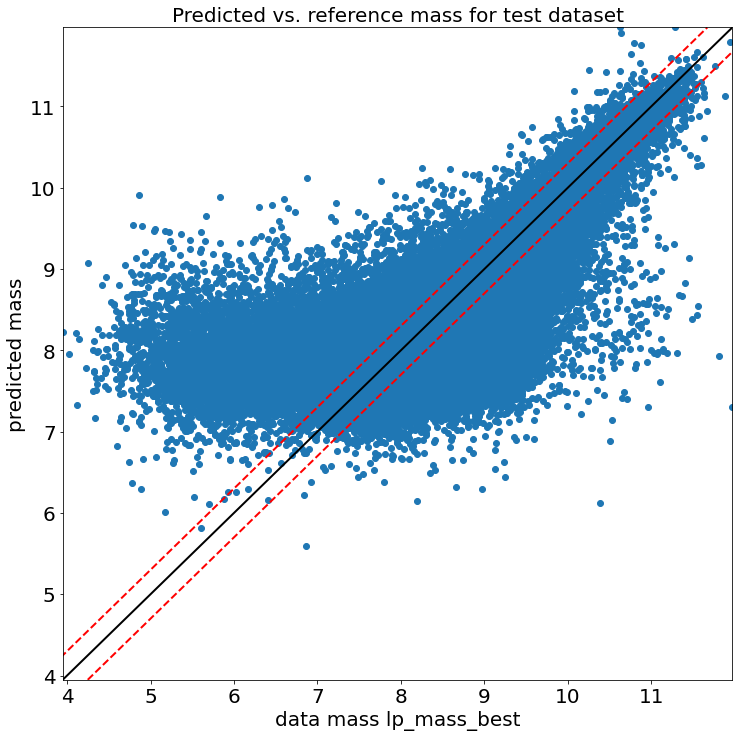

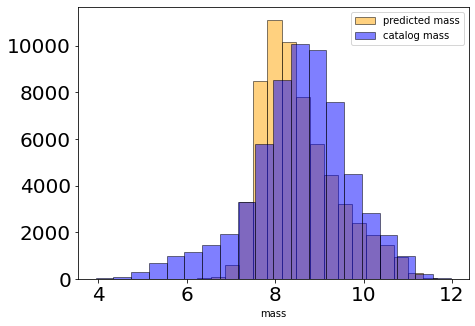

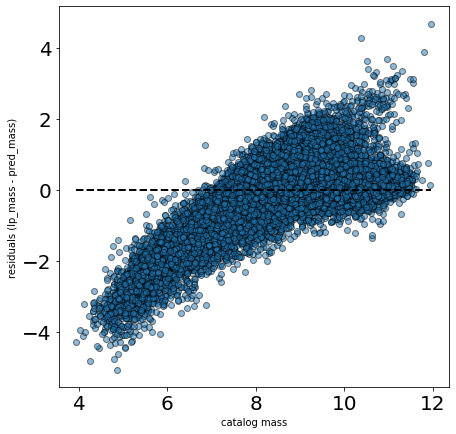

In [22]:
#Test:

model = catboost.CatBoostRegressor(n_estimators = 150, max_depth = 9, verbose = 0)
model.fit(x_train, y_train, sample_weight = x_err_train) # sample_weight = x_err_train
pred_z = model.predict(x_test)
#Metrics:
outlier_fraction, nmad, bias, r2 = metric_scores_rgr(y_test, pred_z)
print("Outlier fraction: \n", outlier_fraction)
print("\n Bias: \n", bias)
print("\n NMAD score: \n", nmad)
print('\n R2 Test: \n', r2)

plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.scatter(y_test, pred_z)
plt.title('Predicted vs. reference mass for test dataset', fontsize = 20)
plt.xlabel('data mass lp_mass_best', fontsize = 20)
plt.ylabel('predicted mass', fontsize = 20)
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = np.min(y_test), np.max(y_test)
plt.xlim(np.min(y_test), np.max(y_test))
plt.ylim(np.min(y_test), np.max(y_test))
plt.plot([np.min(y_test)-0.3, np.max(y_test)-0.30], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([np.min(y_test)+0.3, np.max(y_test)+0.30], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2)


# Histogram:
fig_hist = plt.figure(figsize=(7,5))
plt.hist(pred_z, 20,facecolor='orange', edgecolor = 'black', alpha=0.5, label = 'predicted mass')
plt.hist(y_test, 20, facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'catalog mass')
plt.xlabel('mass')
plt.legend()
# Residuals:
residuals = y_test - pred_z
fig_res = plt.figure(figsize=(7,7))
plt.scatter(y_test, residuals, alpha = 0.5, edgecolor = 'black')
plt.xlabel('catalog mass')
plt.ylabel('residuals (lp_mass - pred_mass)')
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = 0, 0
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2, linestyle = 'dashed')

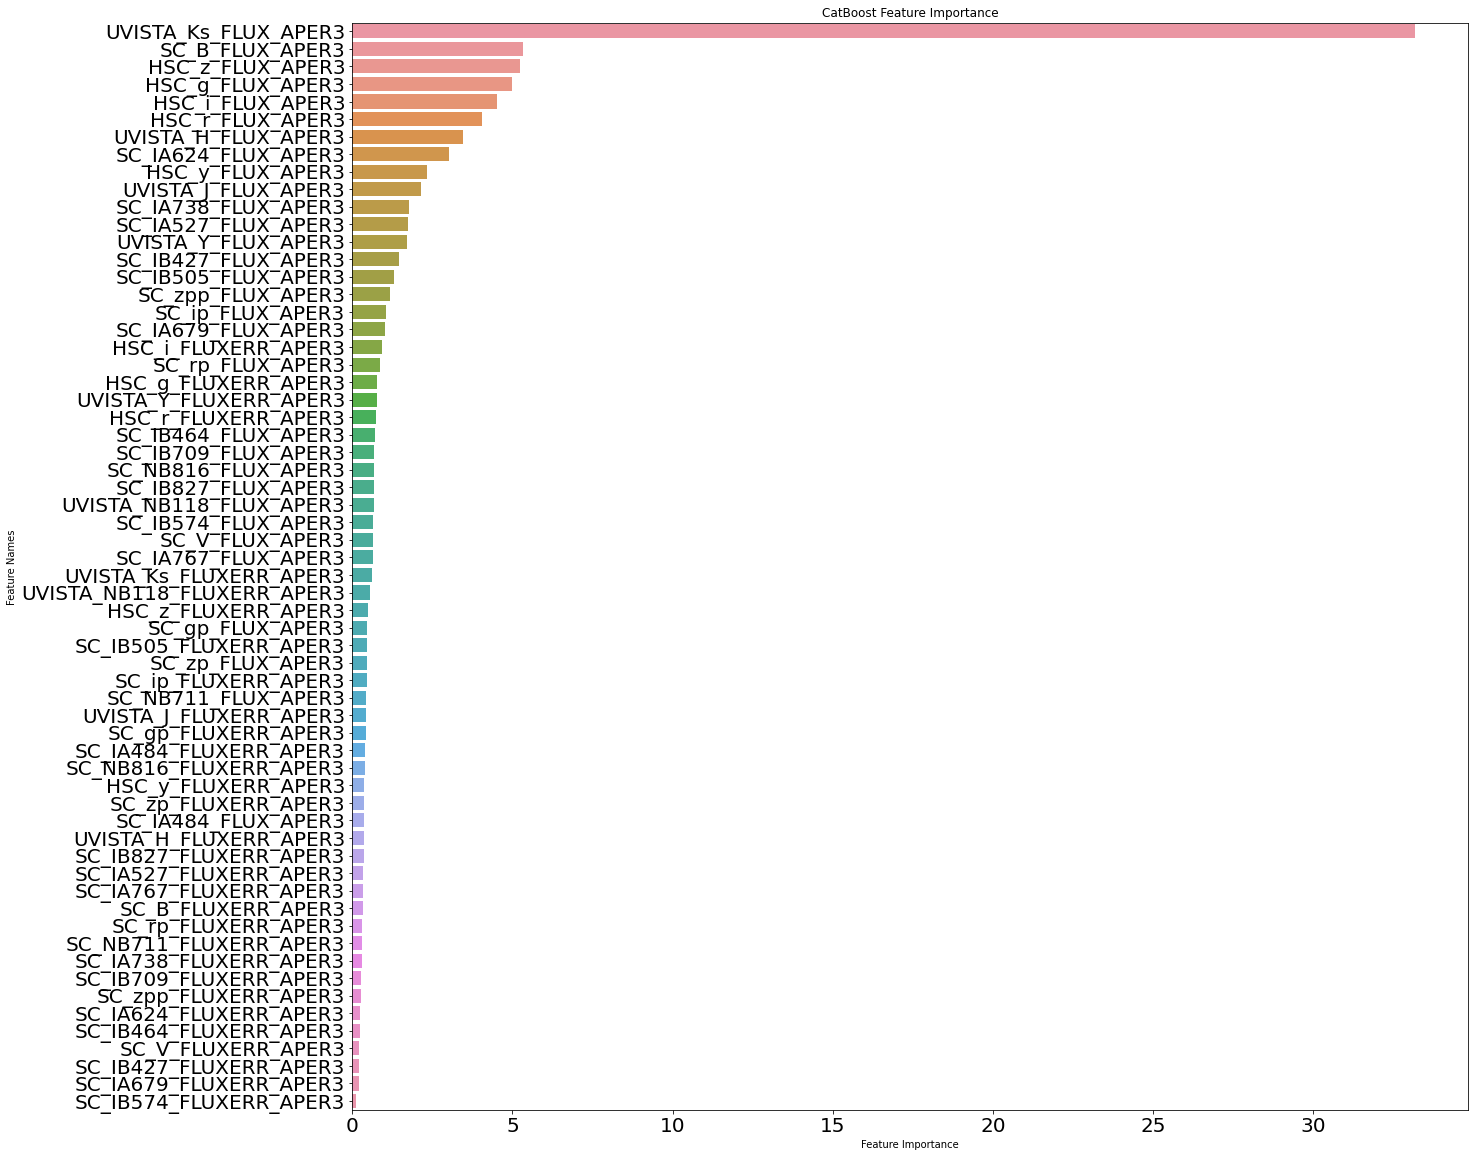

In [23]:
# Feature importance:
def plot_feature_importance(importance,names,model_type):
    """Plots feature importance
    importance: features importance output from model
    names: features names
    model_type: name of the model used to compute features importance
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

features_importances = model.feature_importances_ #replace model by your model
names = np.array(['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3'])#list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.

plot_feature_importance(features_importances,names,model_type)

# SFR

In [24]:
#Group columns into features (x) and labels (y), with their errors:
y = data[['lp_zBEST', 'lp_age', 'lp_dust', 'lp_mass_best', 'lp_SFR_best']].copy()
x = data[['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()
y_z_err = data[['lp_chi2_best']].copy()
x_err = data[['HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3']].copy()

#Train validation test split:
x_train, x_testval, y_train, y_testval, x_err_train, x_err_testval = train_test_split(x, y, x_err, test_size=0.3, shuffle = True)
x_test, x_val, y_test, y_val , x_err_test, x_err_val = train_test_split(x_testval, y_testval, x_err_testval, test_size=0.5, shuffle = True)

In [25]:
y_train = y_train['lp_SFR_best'] #SFR
y_val = y_val['lp_SFR_best']
y_test = y_test['lp_SFR_best']

In [26]:
start = time.time()

def metric_scores_rgr(x,y):
    """Computes the NMAD, bias, outlier fraction for the regression tasks
    x: ground-truth data
    y: predicted data
    """
    met = np.abs(pd.Series(y-x))
    f_out = met
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    #y_outlier = pd.Series(np.where(f_out > 0.30, 'outlier', 'not outlier'))
    r2 = sklearn.metrics.r2_score(x, y)
    #print("Outliers: \n", y_outlier.value_counts())
    #outlier_fraction = y_outlier.value_counts()['outlier'] / len(y_outlier)
    #print("Outlier fraction: \n", outlier_fraction)
    #print("\n Bias: \n", bias)
    #print("\n NMAD score: \n", nmad)
    #print('\n R2 Test: \n', r2)
    return nmad, bias, r2


metrics = {'n_estimators': [], 'max_depth': [], 'NMAD': [], 'bias': [], 'r2': []}
metrics = pd.DataFrame(data=metrics)
for i in [50, 100, 150]:
    for j in [0, 4, 7, 9]:
        metrics['n_estimators']
        model = catboost.CatBoostRegressor(n_estimators = i, max_depth = j, verbose = 0, nan_mode = 'Min')
        model.fit(x_train, y_train) # sample_weight = x_err_train
        pred_z = model.predict(x_val)
        # Tests for metric tuning:
        nmad, bias, r2 = metric_scores_rgr(y_val, pred_z)
        new_row = pd.DataFrame([[i, j, nmad, bias, r2]], columns=['n_estimators', 'max_depth', 'NMAD', 'bias', 'r2'])
        metrics = pd.concat([metrics, new_row], axis = 0)
        
print(metrics)

total_time = (time.time() - start)
print(f'Total needed time for catboost: {total_time/60} minutes')

   n_estimators  max_depth      NMAD      bias        r2
0          50.0        0.0  1.316154  0.889293 -0.000041
0          50.0        4.0  0.815869  0.551263  0.221592
0          50.0        7.0  0.779046  0.526382  0.238361
0          50.0        9.0  0.763572  0.515927  0.247217
0         100.0        0.0  1.316154  0.889293 -0.000041
0         100.0        4.0  0.787243  0.531921  0.235276
0         100.0        7.0  0.755080  0.510189  0.242944
0         100.0        9.0  0.749935  0.506713  0.246661
0         150.0        0.0  1.316154  0.889293 -0.000041
0         150.0        4.0  0.781223  0.527853  0.239173
0         150.0        7.0  0.753097  0.508850  0.245722
0         150.0        9.0  0.744824  0.503259  0.242369
Total needed time for catboost: 1.624864383538564 minutes



 Bias: 
 0.5018005646191663

 NMAD score: 
 0.7426648356363662

 R2 Test: 
 0.25078479595782377


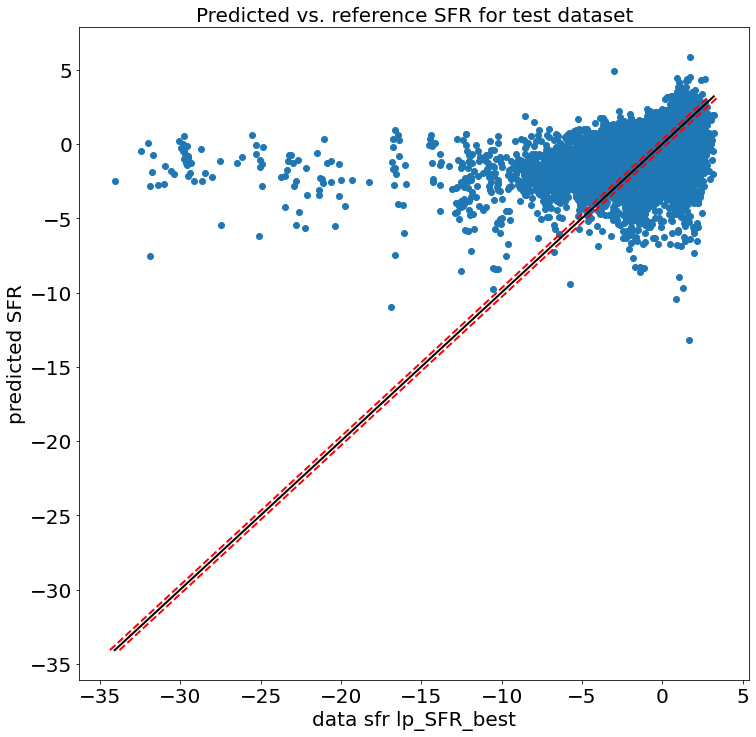

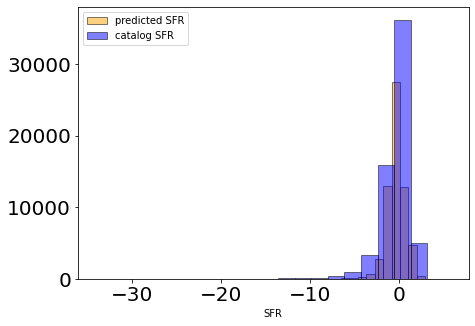

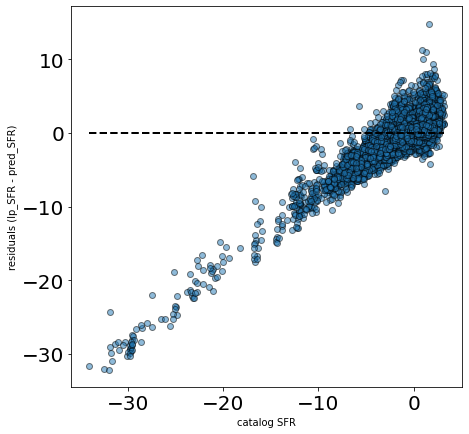

In [27]:
#Test:

model = catboost.CatBoostRegressor(n_estimators = 150, max_depth = 9, verbose = 0)
model.fit(x_train, y_train) # sample_weight = x_err_train
pred_z = model.predict(x_test)
#Metrics:
nmad, bias, r2 = metric_scores_rgr(y_test, pred_z)
print("\n Bias: \n", bias)
print("\n NMAD score: \n", nmad)
print('\n R2 Test: \n', r2)

plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.scatter(y_test, pred_z)
plt.title('Predicted vs. reference SFR for test dataset', fontsize = 20)
plt.xlabel('data sfr lp_SFR_best', fontsize = 20)
plt.ylabel('predicted SFR', fontsize = 20)
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = np.min(y_test), np.max(y_test)
plt.plot([np.min(y_test)-0.3, np.max(y_test)-0.30], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([np.min(y_test)+0.3, np.max(y_test)+0.30], [y0, y1], color = 'red', linewidth = 2, linestyle = 'dashed')
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2)


# Histogram:
fig_hist = plt.figure(figsize=(7,5))
plt.hist(pred_z, 20,facecolor='orange', edgecolor = 'black', alpha=0.5, label = 'predicted SFR')
plt.hist(y_test, 20, facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'catalog SFR')
plt.xlabel('SFR')
plt.legend()
# Residuals:
residuals = y_test - pred_z
fig_res = plt.figure(figsize=(7,7))
plt.scatter(y_test, residuals, alpha = 0.5, edgecolor = 'black')
plt.xlabel('catalog SFR')
plt.ylabel('residuals (lp_SFR - pred_SFR)')
x0, x1 = np.min(y_test), np.max(y_test)
y0, y1 = 0, 0
plt.plot([x0, x1], [y0, y1], color = 'black', linewidth = 2, linestyle = 'dashed')

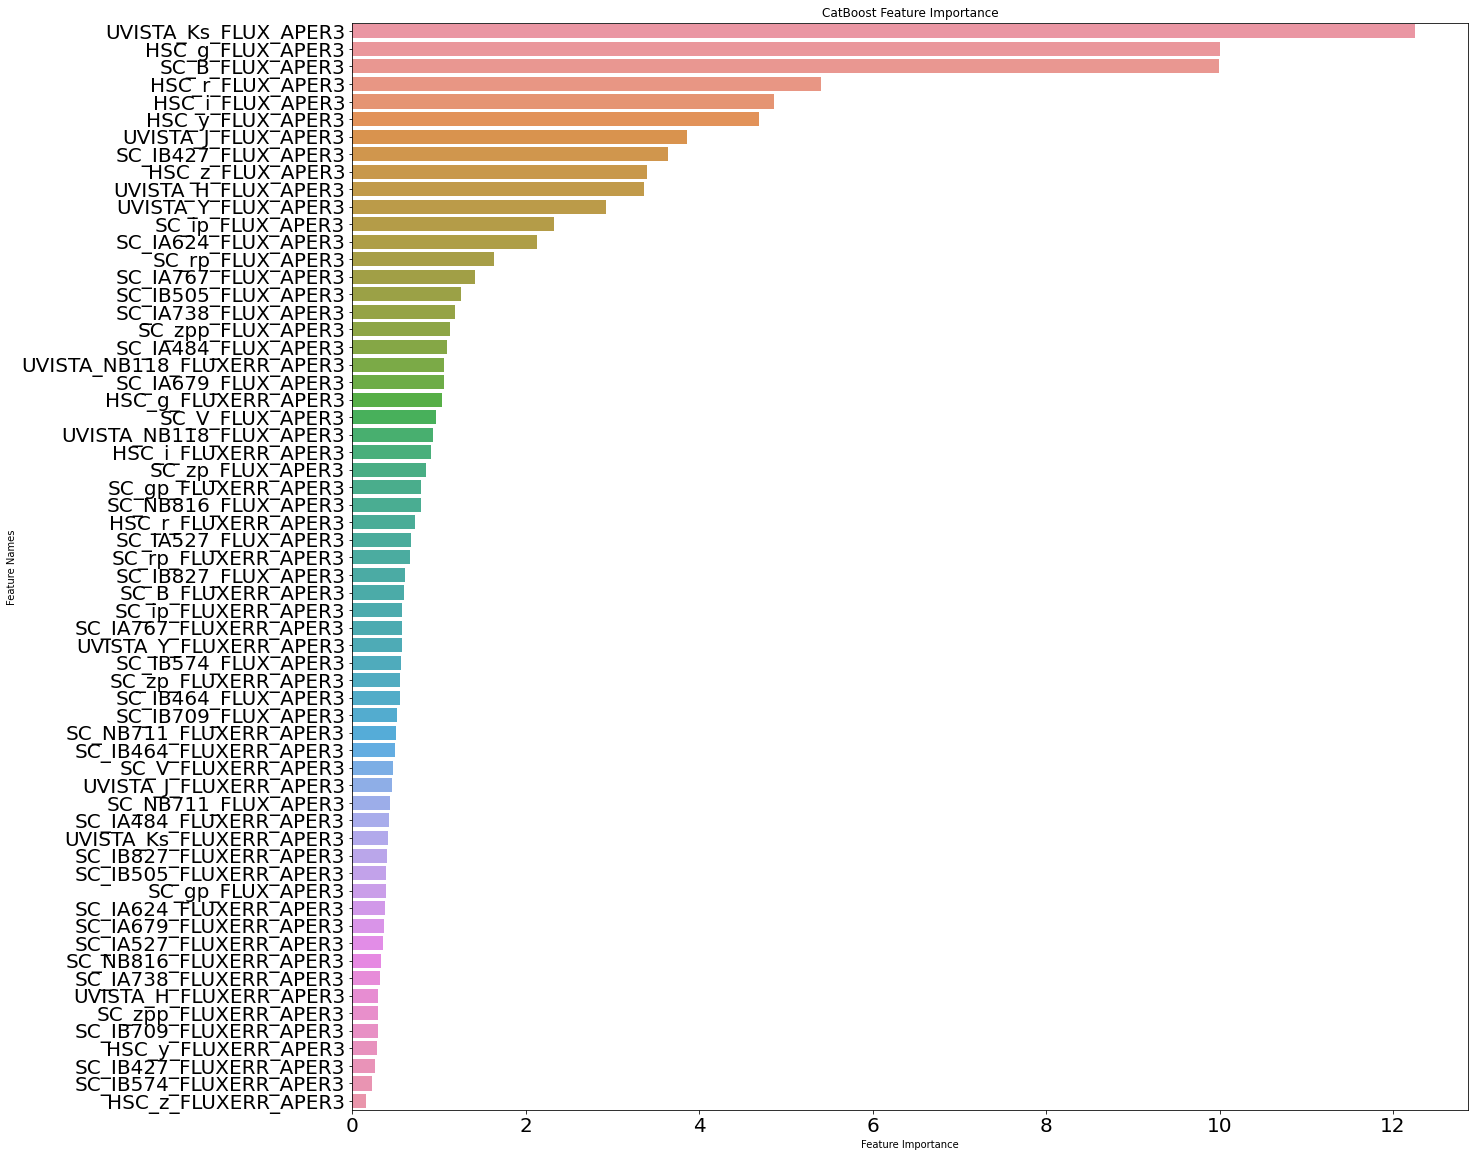

In [28]:
# Feature importance:
def plot_feature_importance(importance,names,model_type):
    """Plots feature importance
    importance: features importance output from model
    names: features names
    model_type: name of the model used to compute features importance
    """

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

features_importances = model.feature_importances_ #replace model by your model
names = np.array(['HSC_g_FLUX_APER3', 'HSC_r_FLUX_APER3', 'HSC_i_FLUX_APER3',
                 'HSC_z_FLUX_APER3', 'HSC_y_FLUX_APER3', 'UVISTA_Y_FLUX_APER3',
                 'UVISTA_J_FLUX_APER3', 'UVISTA_H_FLUX_APER3', 'UVISTA_Ks_FLUX_APER3',
                 'SC_IB427_FLUX_APER3', 'SC_IB464_FLUX_APER3', 'SC_IA484_FLUX_APER3',
                 'SC_IB505_FLUX_APER3', 'SC_IA527_FLUX_APER3', 'SC_IB574_FLUX_APER3', 
                 'SC_IA624_FLUX_APER3', 'SC_IA679_FLUX_APER3', 'SC_IB709_FLUX_APER3', 
                 'SC_IA738_FLUX_APER3', 'SC_IA767_FLUX_APER3', 'SC_IB827_FLUX_APER3', 
                 'SC_NB711_FLUX_APER3', 'SC_NB816_FLUX_APER3', 'UVISTA_NB118_FLUX_APER3', 
                 'SC_B_FLUX_APER3', 'SC_gp_FLUX_APER3', 'SC_V_FLUX_APER3', 'SC_rp_FLUX_APER3', 
                 'SC_ip_FLUX_APER3', 'SC_zp_FLUX_APER3', 'SC_zpp_FLUX_APER3', 'HSC_g_FLUXERR_APER3', 'HSC_r_FLUXERR_APER3', 'HSC_i_FLUXERR_APER3',
                 'HSC_z_FLUXERR_APER3', 'HSC_y_FLUXERR_APER3', 'UVISTA_Y_FLUXERR_APER3',
                 'UVISTA_J_FLUXERR_APER3', 'UVISTA_H_FLUXERR_APER3', 'UVISTA_Ks_FLUXERR_APER3',
                 'SC_IB427_FLUXERR_APER3', 'SC_IB464_FLUXERR_APER3', 'SC_IA484_FLUXERR_APER3',
                 'SC_IB505_FLUXERR_APER3', 'SC_IA527_FLUXERR_APER3', 'SC_IB574_FLUXERR_APER3', 
                 'SC_IA624_FLUXERR_APER3', 'SC_IA679_FLUXERR_APER3', 'SC_IB709_FLUXERR_APER3', 
                 'SC_IA738_FLUXERR_APER3', 'SC_IA767_FLUXERR_APER3', 'SC_IB827_FLUXERR_APER3', 
                 'SC_NB711_FLUXERR_APER3', 'SC_NB816_FLUXERR_APER3', 'UVISTA_NB118_FLUXERR_APER3', 
                 'SC_B_FLUXERR_APER3', 'SC_gp_FLUXERR_APER3', 'SC_V_FLUXERR_APER3', 'SC_rp_FLUXERR_APER3', 
                 'SC_ip_FLUXERR_APER3', 'SC_zp_FLUXERR_APER3', 'SC_zpp_FLUXERR_APER3'])#list of the columns from the X_train data set
model_type = 'CatBoost' # change according to the model to be used. Only used in the plots.

plot_feature_importance(features_importances,names,model_type)

In [29]:
y_train.value_counts()

 1.05800    92
 1.03000    92
 1.07100    89
 1.07900    88
 1.07600    87
            ..
 0.03681     1
 0.07221     1
 0.01111     1
-0.06328     1
-3.81000     1
Name: lp_SFR_best, Length: 40330, dtype: int64

In [30]:
y_train.astype('int32')

144155   -2
108302    0
693788   -1
577298    0
120353    0
         ..
123993    0
681733    0
697034    0
356939    0
392736    0
Name: lp_SFR_best, Length: 289295, dtype: int32